## 10-fold CV with 3-layer CNN avg pooling on real image

### Import and env settings

In [65]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import os

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.min_rows', 50)

### Variables/parameters used in this notebook

In [69]:
ckpt_path = "./ckpt/5_class_lr005/"
os.makedirs(ckpt_path, exist_ok=True)

lr = 0.005
epochs = 120

### Prepare data

In [10]:
df = pd.read_csv('../../data/images/label.csv')
df.head()

labels = df['SalePrice'].to_numpy()
labels.shape


(2911,)

In [52]:
images_arr = []

for i in range(1, len(labels)+1):
# for i in range(1, 10):
    img = plt.imread('../../data/images/img_{}.png'.format(i))
    images_arr.append(img)

images_arr = np.array(images_arr, dtype='float32')
images_arr.shape
    


(2911, 18, 18, 3)

#### train test splitting
- hold out 15% for testing
- use 85% to train model with K-fold CV

In [53]:
ttl_samples = images_arr.shape[0] 
test_ratio = 0.15
test_samples = int(test_ratio * images_arr.shape[0])

train_examples = images_arr[:-1*test_samples]
test_examples = images_arr[-1*test_samples:]
train_labels = labels[:-1*test_samples]
test_labels = labels[-1*test_samples:]


In [54]:
print('train: ', train_examples.shape)
print('test: ', test_examples.shape)
print('train label: ', train_labels.shape)
print('test label: ', test_labels.shape)

train:  (2475, 18, 18, 3)
test:  (436, 18, 18, 3)
train label:  (2475,)
test label:  (436,)


### Prepare model

In [71]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def create_reg_model(lr=0.005):

	# Working
	with tf.device('/cpu:0'):
		data_augmentation = tf.keras.Sequential([ 
			tf.keras.layers.RandomFlip("horizontal", input_shape=(18, 18, 3)),
	  		tf.keras.layers.RandomRotation(0.1),
		    tf.keras.layers.RandomZoom(0.1)
			])


	model = tf.keras.Sequential([
		# data_augmentation,
	  	# tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
	  	tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(18, 18,3)),
		tf.keras.layers.MaxPooling2D((2, 2)),
		tf.keras.layers.Dropout(0.1),
		tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
	  	tf.keras.layers.MaxPooling2D((2,2)),
		tf.keras.layers.Dropout(0.1),
	  	tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
	  	tf.keras.layers.MaxPooling2D(),
		tf.keras.layers.Dropout(0.1),
		tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(128, activation='relu'),
		tf.keras.layers.Dense(64, activation='relu'),
		tf.keras.layers.Dense(32, activation='relu'),
		tf.keras.layers.Dense(1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
	])

	# opt = tf.keras.optimizers.SGD(lr=0.005, momentum=0.9)
	opt = tf.keras.optimizers.Adam(lr=lr)
	model.compile(optimizer=opt, loss=rmse, metrics=[rmse])

	return model


Num GPUs Available:  1


In [72]:
model = create_reg_model()
# model.summary()

In [73]:
history = model.fit(train_examples, train_labels, epochs=epochs, validation_data=(test_examples, test_labels))

Epoch 1/120


2022-04-30 20:50:03.557976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - ETA: 0s - loss: 95512.2734 - rmse: 95671.0078

2022-04-30 20:50:04.762280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 2s 16ms/step - loss: 95512.2734 - rmse: 95671.0078 - val_loss: 46192.8984 - val_rmse: 46322.1328
Epoch 2/120
78/78 [==============================] - 1s 10ms/step - loss: 48993.8359 - rmse: 48968.6094 - val_loss: 40018.5352 - val_rmse: 39877.3320
Epoch 3/120
78/78 [==============================] - 1s 11ms/step - loss: 44634.4922 - rmse: 44568.5156 - val_loss: 36631.5977 - val_rmse: 36475.7930
Epoch 4/120
78/78 [==============================] - 1s 10ms/step - loss: 41324.1562 - rmse: 41232.6250 - val_loss: 35772.6680 - val_rmse: 35660.4805
Epoch 5/120
78/78 [==============================] - 1s 10ms/step - loss: 40260.8516 - rmse: 40181.1016 - val_loss: 33804.9883 - val_rmse: 33669.9688
Epoch 6/120
78/78 [==============================] - 1s 10ms/step - loss: 36824.9883 - rmse: 36819.2109 - val_loss: 31658.4102 - val_rmse: 31540.8496
Epoch 7/120
78/78 [==============================] - 1s 10ms/step - loss: 35794.9961 - rmse: 35824.4766 - val_lo

2022-04-30 20:59:25.822738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/evantilu/miniforge3/envs/6998_DL_tf/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


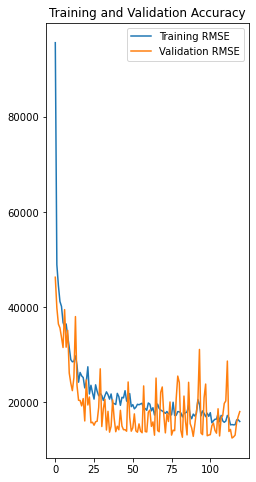

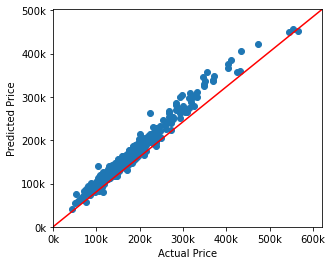

In [74]:
train_rmse = history.history['rmse']
val_rmse = history.history['val_rmse']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_rmse, label='Training RMSE')
plt.plot(epochs_range, val_rmse, label='Validation RMSE')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')


'''How far are predictions from real values?'''
from matplotlib.ticker import FuncFormatter

def format_tick_labels(x, pos):
    return '{:.0f}k'.format(x/1000)

predictions = model.predict(test_examples)

xlims = [0, max(test_labels)*1.1]
ylims = [0, max(predictions)*1.1]

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(test_labels, predictions)
ax.xaxis.set_major_formatter(FuncFormatter(format_tick_labels))
ax.yaxis.set_major_formatter(FuncFormatter(format_tick_labels))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')

ax.plot(xlims, ylims, 'r-')

### K-fold CV Training

In [75]:
from sklearn.model_selection import KFold

# modify to save ckpt for each test
ckpt = os.path.join(ckpt_path, "val_rmse_{val_rmse:.0f}.hdf5")

# training params
epochs = epochs
lr = lr

# the k for k fold CV
n_split = 10

# for recording best performance
min_loss = np.inf
best_history = None

'''
k-fold cross validation
Save the best model using validation accuracy as metric
Print the global best performace when finished
'''
for train_index, test_index in KFold(n_split).split(train_examples):

    x_train, x_vad = train_examples[train_index], train_examples[test_index]
    y_train, y_vad = train_labels[train_index], train_labels[test_index]

    model=create_reg_model(lr)
  
    # callbacks
    checkpoint_filepath = ckpt
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='auto',
        save_best_only=True,
        verbose=1
    )

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=25,
        verbose=1,
        mode='auto',
    )

    # Model weights are saved at the end of every epoch, if it's the best seen so far.
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_vad, y_vad),
                        callbacks=[model_checkpoint_callback, early_stopping_callback])

    val_loss = max(history.history['val_loss'])
    
    if val_loss < min_loss:
        min_loss = val_loss
        best_history = history
        # print('Best acc so far. Saving params...\n')

print('Finish {}-fold cross validation'.format(n_split))
print('Best performing model has {} validation loss (RMSE)'.format(min_loss))



Epoch 1/120


2022-04-30 21:01:58.771360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 101276.9141 - rmse: 101016.1172

2022-04-30 21:01:59.988228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 55759.26562, saving model to ./ckpt/5_class_lr005/val_rmse_55878.hdf5
70/70 [==============================] - 2s 18ms/step - loss: 101276.9141 - rmse: 101016.1172 - val_loss: 55759.2656 - val_rmse: 55878.2852
Epoch 2/120
66/70 [===========================>..] - ETA: 0s - loss: 53699.6992 - rmse: 53699.6992
Epoch 2: val_loss improved from 55759.26562 to 50398.23828, saving model to ./ckpt/5_class_lr005/val_rmse_50269.hdf5
70/70 [==============================] - 1s 9ms/step - loss: 54629.2852 - rmse: 54733.3594 - val_loss: 50398.2383 - val_rmse: 50268.8984
Epoch 3/120
65/70 [==========================>...] - ETA: 0s - loss: 47985.3516 - rmse: 47985.3516
Epoch 3: val_loss did not improve from 50398.23828
70/70 [==============================] - 1s 10ms/step - loss: 47690.5352 - rmse: 47936.6758 - val_loss: 51784.5195 - val_rmse: 51601.8203
Epoch 4/120
70/70 [==============================] - ETA: 0s - loss: 43200.7383 - rmse: 43315.7891
Epoch 4: v

2022-04-30 21:03:24.194863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 99976.8438 - rmse: 99958.3750  
Epoch 1: val_loss improved from inf to 61005.45703, saving model to ./ckpt/5_class_lr005/val_rmse_61484.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 99976.8438 - rmse: 99958.3750 - val_loss: 61005.4570 - val_rmse: 61484.0898
Epoch 2/120
 7/70 [==>...........................] - ETA: 0s - loss: 64392.9766 - rmse: 64392.9766

2022-04-30 21:03:25.154680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/70 [===========================>..] - ETA: 0s - loss: 52371.5898 - rmse: 52371.5898
Epoch 2: val_loss improved from 61005.45703 to 47753.56250, saving model to ./ckpt/5_class_lr005/val_rmse_48205.hdf5
70/70 [==============================] - 1s 10ms/step - loss: 52340.2422 - rmse: 52229.4023 - val_loss: 47753.5625 - val_rmse: 48204.9414
Epoch 3/120
67/70 [===========================>..] - ETA: 0s - loss: 46270.3516 - rmse: 46270.3516
Epoch 3: val_loss improved from 47753.56250 to 46550.01953, saving model to ./ckpt/5_class_lr005/val_rmse_46967.hdf5
70/70 [==============================] - 1s 10ms/step - loss: 45827.8555 - rmse: 45715.5000 - val_loss: 46550.0195 - val_rmse: 46967.2031
Epoch 4/120
69/70 [============================>.] - ETA: 0s - loss: 45275.9023 - rmse: 45275.9023
Epoch 4: val_loss improved from 46550.01953 to 44515.36328, saving model to ./ckpt/5_class_lr005/val_rmse_44852.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 45162.0859 - rmse: 45085.3

2022-04-30 21:04:14.825571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 99603.5625 - rmse: 99221.7266  
Epoch 1: val_loss improved from inf to 63218.00391, saving model to ./ckpt/5_class_lr005/val_rmse_62431.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 99603.5625 - rmse: 99221.7266 - val_loss: 63218.0039 - val_rmse: 62431.2422
Epoch 2/120
 7/70 [==>...........................] - ETA: 0s - loss: 64704.2617 - rmse: 64704.2617

2022-04-30 21:04:15.764258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


64/70 [==========================>...] - ETA: 0s - loss: 52272.9766 - rmse: 52272.9766
Epoch 2: val_loss improved from 63218.00391 to 61370.55078, saving model to ./ckpt/5_class_lr005/val_rmse_61182.hdf5
70/70 [==============================] - 1s 9ms/step - loss: 52055.2773 - rmse: 52019.9727 - val_loss: 61370.5508 - val_rmse: 61182.4492
Epoch 3/120
66/70 [===========================>..] - ETA: 0s - loss: 46417.8125 - rmse: 46417.8125
Epoch 3: val_loss improved from 61370.55078 to 49498.93750, saving model to ./ckpt/5_class_lr005/val_rmse_49220.hdf5
70/70 [==============================] - 1s 9ms/step - loss: 46255.2227 - rmse: 46183.0430 - val_loss: 49498.9375 - val_rmse: 49219.6289
Epoch 4/120
67/70 [===========================>..] - ETA: 0s - loss: 44943.9375 - rmse: 44943.9375
Epoch 4: val_loss improved from 49498.93750 to 48845.73047, saving model to ./ckpt/5_class_lr005/val_rmse_48673.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 44469.9922 - rmse: 44421.773

2022-04-30 21:05:07.002444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 104868.4453 - rmse: 104603.3906
Epoch 1: val_loss improved from inf to 65411.21484, saving model to ./ckpt/5_class_lr005/val_rmse_65729.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 104868.4453 - rmse: 104603.3906 - val_loss: 65411.2148 - val_rmse: 65729.4609
Epoch 2/120
 7/70 [==>...........................] - ETA: 0s - loss: 63605.5312 - rmse: 63605.5312

2022-04-30 21:05:07.911122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 52661.8281 - rmse: 52604.0820
Epoch 2: val_loss improved from 65411.21484 to 47740.94922, saving model to ./ckpt/5_class_lr005/val_rmse_47736.hdf5
70/70 [==============================] - 1s 10ms/step - loss: 52661.8281 - rmse: 52604.0820 - val_loss: 47740.9492 - val_rmse: 47736.4922
Epoch 3/120
70/70 [==============================] - ETA: 0s - loss: 46784.0391 - rmse: 46711.5312
Epoch 3: val_loss improved from 47740.94922 to 44796.26953, saving model to ./ckpt/5_class_lr005/val_rmse_44680.hdf5
70/70 [==============================] - 1s 9ms/step - loss: 46784.0391 - rmse: 46711.5312 - val_loss: 44796.2695 - val_rmse: 44680.2617
Epoch 4/120
70/70 [==============================] - ETA: 0s - loss: 44141.6055 - rmse: 44077.4531
Epoch 4: val_loss improved from 44796.26953 to 43286.99609, saving model to ./ckpt/5_class_lr005/val_rmse_43071.hdf5
70/70 [==============================] - 1s 11ms/step - loss: 44141.6055 - rmse: 44077.45

2022-04-30 21:06:26.125008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 103386.3828 - rmse: 103060.8672
Epoch 1: val_loss improved from inf to 59296.08203, saving model to ./ckpt/5_class_lr005/val_rmse_59494.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 103386.3828 - rmse: 103060.8672 - val_loss: 59296.0820 - val_rmse: 59493.7891
Epoch 2/120
 1/70 [..............................] - ETA: 0s - loss: 71340.3828 - rmse: 71340.3828

2022-04-30 21:06:27.150831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/70 [===========================>..] - ETA: 0s - loss: 53042.9141 - rmse: 53042.9141
Epoch 2: val_loss improved from 59296.08203 to 49207.90234, saving model to ./ckpt/5_class_lr005/val_rmse_49432.hdf5
70/70 [==============================] - 1s 9ms/step - loss: 52804.0938 - rmse: 52771.3164 - val_loss: 49207.9023 - val_rmse: 49431.6406
Epoch 3/120
69/70 [============================>.] - ETA: 0s - loss: 46238.1328 - rmse: 46238.1328
Epoch 3: val_loss improved from 49207.90234 to 45162.72266, saving model to ./ckpt/5_class_lr005/val_rmse_45232.hdf5
70/70 [==============================] - 1s 10ms/step - loss: 46213.1602 - rmse: 46196.3164 - val_loss: 45162.7227 - val_rmse: 45232.2031
Epoch 4/120
66/70 [===========================>..] - ETA: 0s - loss: 42684.3281 - rmse: 42684.3281
Epoch 4: val_loss did not improve from 45162.72266
70/70 [==============================] - 1s 11ms/step - loss: 42409.7070 - rmse: 42364.1797 - val_loss: 50426.7734 - val_rmse: 50502.3945
Epoch 5/120
66/70

2022-04-30 21:07:34.481170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 102259.3203 - rmse: 102006.1250

2022-04-30 21:07:35.456879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 55711.91406, saving model to ./ckpt/5_class_lr005/val_rmse_56819.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 102259.3203 - rmse: 102006.1250 - val_loss: 55711.9141 - val_rmse: 56818.8281
Epoch 2/120
68/70 [============================>.] - ETA: 0s - loss: 51427.1992 - rmse: 51427.1992
Epoch 2: val_loss improved from 55711.91406 to 44818.43359, saving model to ./ckpt/5_class_lr005/val_rmse_45541.hdf5
70/70 [==============================] - 1s 10ms/step - loss: 51943.0703 - rmse: 52066.5820 - val_loss: 44818.4336 - val_rmse: 45540.9453
Epoch 3/120
68/70 [============================>.] - ETA: 0s - loss: 46509.1992 - rmse: 46509.1992
Epoch 3: val_loss improved from 44818.43359 to 41720.85156, saving model to ./ckpt/5_class_lr005/val_rmse_42186.hdf5
70/70 [==============================] - 1s 11ms/step - loss: 46285.9141 - rmse: 46226.3672 - val_loss: 41720.8516 - val_rmse: 42185.7109
Epoch 4/120
70/70 [=======================

2022-04-30 21:08:48.247138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 101436.9922 - rmse: 101596.6875
Epoch 1: val_loss improved from inf to 53297.80469, saving model to ./ckpt/5_class_lr005/val_rmse_52962.hdf5
70/70 [==============================] - 2s 15ms/step - loss: 101436.9922 - rmse: 101596.6875 - val_loss: 53297.8047 - val_rmse: 52962.0703
Epoch 2/120
 6/70 [=>............................] - ETA: 0s - loss: 59707.6641 - rmse: 59707.6641

2022-04-30 21:08:49.386066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


65/70 [==========================>...] - ETA: 0s - loss: 54147.1094 - rmse: 54147.1094
Epoch 2: val_loss improved from 53297.80469 to 40897.62500, saving model to ./ckpt/5_class_lr005/val_rmse_40833.hdf5
70/70 [==============================] - 1s 9ms/step - loss: 53073.1211 - rmse: 53031.3633 - val_loss: 40897.6250 - val_rmse: 40832.6758
Epoch 3/120
68/70 [============================>.] - ETA: 0s - loss: 48350.9375 - rmse: 48350.9375
Epoch 3: val_loss did not improve from 40897.62500
70/70 [==============================] - 1s 11ms/step - loss: 48002.1094 - rmse: 47897.7734 - val_loss: 43347.4219 - val_rmse: 43480.0547
Epoch 4/120
70/70 [==============================] - ETA: 0s - loss: 43526.7305 - rmse: 43501.0664
Epoch 4: val_loss improved from 40897.62500 to 37777.48438, saving model to ./ckpt/5_class_lr005/val_rmse_37538.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 43526.7305 - rmse: 43501.0664 - val_loss: 37777.4844 - val_rmse: 37538.0469
Epoch 5/120
65/70

2022-04-30 21:09:27.960100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 100631.2188 - rmse: 100361.6484
Epoch 1: val_loss improved from inf to 53638.03516, saving model to ./ckpt/5_class_lr005/val_rmse_56067.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 100631.2188 - rmse: 100361.6484 - val_loss: 53638.0352 - val_rmse: 56067.4062
Epoch 2/120


2022-04-30 21:09:29.052533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 52982.0117 - rmse: 52937.7891
Epoch 2: val_loss improved from 53638.03516 to 39879.98828, saving model to ./ckpt/5_class_lr005/val_rmse_41710.hdf5
70/70 [==============================] - 1s 10ms/step - loss: 52982.0117 - rmse: 52937.7891 - val_loss: 39879.9883 - val_rmse: 41709.6758
Epoch 3/120
65/70 [==========================>...] - ETA: 0s - loss: 46302.3086 - rmse: 46302.3086
Epoch 3: val_loss improved from 39879.98828 to 35649.89062, saving model to ./ckpt/5_class_lr005/val_rmse_37695.hdf5
70/70 [==============================] - 1s 10ms/step - loss: 47218.0039 - rmse: 47165.3242 - val_loss: 35649.8906 - val_rmse: 37695.0234
Epoch 4/120
68/70 [============================>.] - ETA: 0s - loss: 45246.7852 - rmse: 45246.7852
Epoch 4: val_loss did not improve from 35649.89062
70/70 [==============================] - 1s 11ms/step - loss: 45020.9375 - rmse: 44992.9492 - val_loss: 39358.4961 - val_rmse: 41362.5000
Epoch 5/120
68/7

2022-04-30 21:10:15.665049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 106009.5234 - rmse: 105738.6953
Epoch 1: val_loss improved from inf to 43910.97656, saving model to ./ckpt/5_class_lr005/val_rmse_44142.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 106009.5234 - rmse: 105738.6953 - val_loss: 43910.9766 - val_rmse: 44141.8242
Epoch 2/120
 1/70 [..............................] - ETA: 0s - loss: 58519.4766 - rmse: 58519.4766

2022-04-30 21:10:16.732338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/70 [============================>.] - ETA: 0s - loss: 54881.5078 - rmse: 54881.5078
Epoch 2: val_loss did not improve from 43910.97656
70/70 [==============================] - 1s 9ms/step - loss: 55432.7617 - rmse: 55703.2422 - val_loss: 51572.0625 - val_rmse: 51808.2969
Epoch 3/120
69/70 [============================>.] - ETA: 0s - loss: 51251.5781 - rmse: 51251.5781
Epoch 3: val_loss improved from 43910.97656 to 33892.00000, saving model to ./ckpt/5_class_lr005/val_rmse_33549.hdf5
70/70 [==============================] - 1s 9ms/step - loss: 51196.4219 - rmse: 51163.7969 - val_loss: 33892.0000 - val_rmse: 33548.6016
Epoch 4/120
70/70 [==============================] - ETA: 0s - loss: 44966.2500 - rmse: 44986.6484
Epoch 4: val_loss improved from 33892.00000 to 28774.96680, saving model to ./ckpt/5_class_lr005/val_rmse_28572.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 44966.2500 - rmse: 44986.6484 - val_loss: 28774.9668 - val_rmse: 28572.4805
Epoch 5/120
70/70 

2022-04-30 21:11:12.224327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 100935.4141 - rmse: 100639.5312
Epoch 1: val_loss improved from inf to 60587.43359, saving model to ./ckpt/5_class_lr005/val_rmse_59514.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 100935.4141 - rmse: 100639.5312 - val_loss: 60587.4336 - val_rmse: 59514.4180
Epoch 2/120


2022-04-30 21:11:13.272153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/70 [===========================>..] - ETA: 0s - loss: 52399.1680 - rmse: 52399.1680
Epoch 2: val_loss improved from 60587.43359 to 44495.48828, saving model to ./ckpt/5_class_lr005/val_rmse_43729.hdf5
70/70 [==============================] - 1s 9ms/step - loss: 51922.3008 - rmse: 51890.1211 - val_loss: 44495.4883 - val_rmse: 43729.2461
Epoch 3/120
67/70 [===========================>..] - ETA: 0s - loss: 46842.6016 - rmse: 46842.6016
Epoch 3: val_loss did not improve from 44495.48828
70/70 [==============================] - 1s 10ms/step - loss: 46232.5703 - rmse: 46138.0273 - val_loss: 46621.3086 - val_rmse: 46083.5859
Epoch 4/120
69/70 [============================>.] - ETA: 0s - loss: 43897.0469 - rmse: 43897.0469
Epoch 4: val_loss improved from 44495.48828 to 38995.86719, saving model to ./ckpt/5_class_lr005/val_rmse_38498.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 43838.0977 - rmse: 43803.2305 - val_loss: 38995.8672 - val_rmse: 38497.6055
Epoch 5/120
70/70

### Visualize training result

2022-04-30 21:16:17.795823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


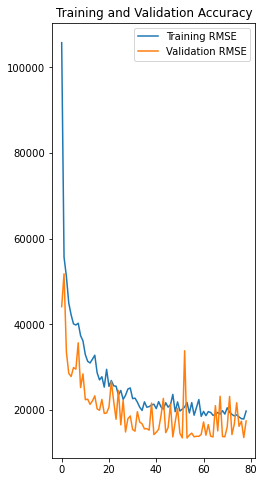

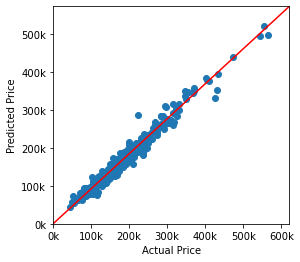

In [76]:
history = best_history

train_rmse = history.history['rmse']
val_rmse = history.history['val_rmse']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_rmse, label='Training RMSE')
plt.plot(epochs_range, val_rmse, label='Validation RMSE')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')


'''How far are predictions from real values?'''
from matplotlib.ticker import FuncFormatter

def format_tick_labels(x, pos):
    return '{:.0f}k'.format(x/1000)

predictions = model.predict(test_examples)

xlims = [0, max(test_labels)*1.1]
ylims = [0, max(predictions)*1.1]

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(test_labels, predictions)
ax.xaxis.set_major_formatter(FuncFormatter(format_tick_labels))
ax.yaxis.set_major_formatter(FuncFormatter(format_tick_labels))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')

ax.plot(xlims, ylims, 'r-')


### Evaluate on test data

In [82]:
model = create_reg_model()
model.load_weights(os.path.join(ckpt_path, "val_rmse_13256.hdf5"))

loss, acc = model.evaluate(test_examples, test_labels)

print('\nevaluation on test set:\nloss (RMSE) = {:.5f}'.format(loss))

 1/14 [=>............................] - ETA: 2s - loss: 10692.5234 - rmse: 10692.5234

2022-04-30 21:17:10.902746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 16ms/step - loss: 14123.4756 - rmse: 14148.6104

evaluation on test set:
loss (RMSE) = 14123.47559


In [151]:
%reset -f